# Bird classification

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [9]:
import pathlib
data_dir = pathlib.Path().absolute()/'Images-X-classes'  # here we consider 10 classes for example
image_count = len(list(data_dir.glob('*/*.jpg')))
print("number of images in total :",image_count)

number of images in total : 1282


# Creating the Dataset

In [10]:
batch_size = 50   # number of images the model trains with at one time, we can also see that the higher the batch, the better our results
img_height = 180
img_width = 180

# Spliting of the data for training and validation
# We chose to have a ratio of 85% for the training and 15% for the validation

training = tf.keras.utils.image_dataset_from_directory( data_dir, validation_split=0.15, subset="training", seed=123,
  image_size=(img_height, img_width), batch_size=batch_size)

validation = tf.keras.utils.image_dataset_from_directory( data_dir, validation_split=0.15, subset="validation", seed=123,
  image_size=(img_height, img_width), batch_size=batch_size)

class_names = training.class_names
print(" We consider the following classes :",class_names)

Found 1287 files belonging to 10 classes.
Using 1094 files for training.
Found 1287 files belonging to 10 classes.
Using 193 files for validation.
 We consider the following classes : ['AMERICAN GOLDFINCH', 'CASSOWARY', 'CROW', 'FLAMINGO', 'GYRFALCON', 'KING VULTURE', 'PEACOCK', 'PINK ROBIN', 'QUETZAL', 'seagull']


# Visualization of the data

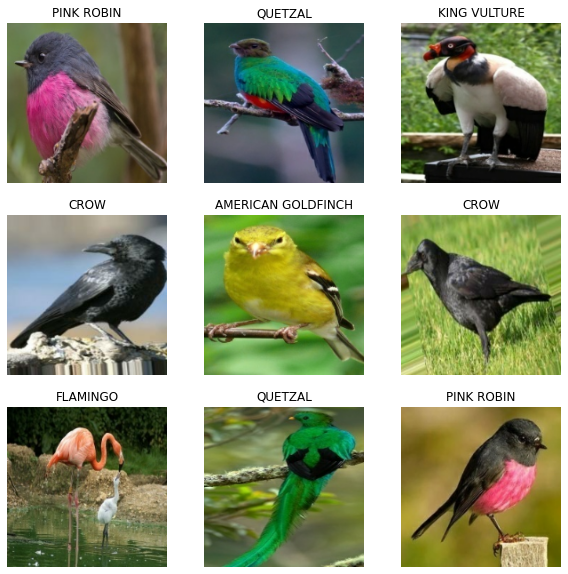

In [11]:
import matplotlib.pyplot as plt

# We display here the first 9 images from the training set with their respective classes

plt.figure(figsize=(10, 10))
for images, labels in training.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
# Configuration
normalization_layer = layers.Rescaling(1./255)  # All the pixel values are now in [0,1]

normalized_data = training.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_data))
first_image = image_batch[0]

# Model creation


In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

Epoch 1/10
22/22 [==============================] - 29s 1s/step - loss: 2.2220 - accuracy: 0.2468 - val_loss: 1.6362 - val_accuracy: 0.4404
Epoch 2/10
22/22 [==============================] - 26s 1s/step - loss: 1.2828 - accuracy: 0.5612 - val_loss: 1.1288 - val_accuracy: 0.6062
Epoch 3/10
22/22 [==============================] - 26s 1s/step - loss: 0.8532 - accuracy: 0.7166 - val_loss: 0.7968 - val_accuracy: 0.7098
Epoch 4/10
22/22 [==============================] - 26s 1s/step - loss: 0.5132 - accuracy: 0.8428 - val_loss: 0.7242 - val_accuracy: 0.7565
Epoch 5/10
22/22 [==============================] - 26s 1s/step - loss: 0.2679 - accuracy: 0.9232 - val_loss: 0.6843 - val_accuracy: 0.7979
Epoch 6/10
22/22 [==============================] - 27s 1s/step - loss: 0.1628 - accuracy: 0.9543 - val_loss: 0.8174 - val_accuracy: 0.7617
Epoch 7/10
22/22 [==============================] - 27s 1s/step - loss: 0.1199 - accuracy: 0.9653 - val_loss: 0.7387 - val_accuracy: 0.7772
Epoch 8/10
22/22 [==

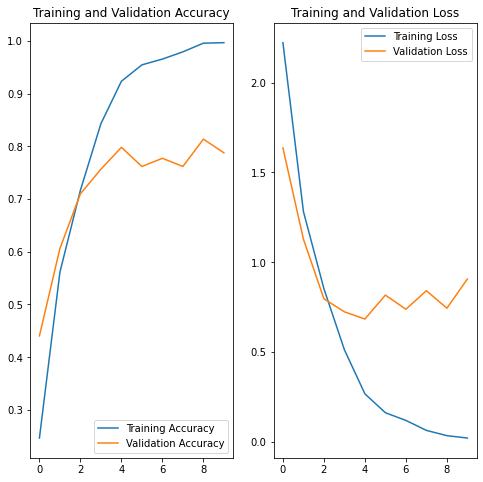

In [14]:
# Training

epochs=10  # We observed that above 10 the results didn't change much so we chose this value
history = model.fit(training, validation_data=validation, epochs=epochs)

# Creation of our curvs
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data augmentation

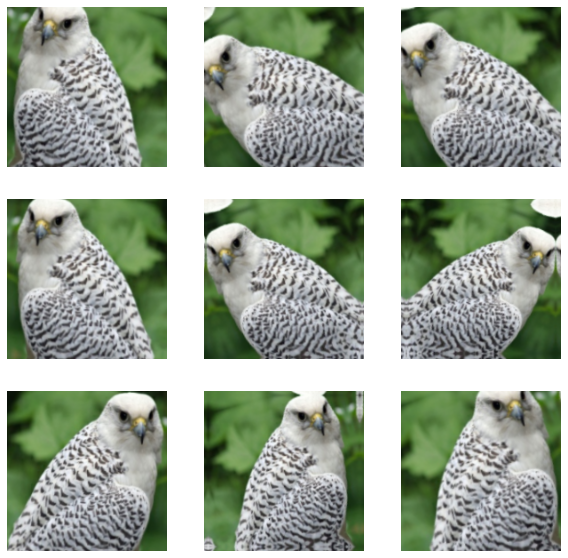

In [15]:
#Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)), layers.RandomRotation(0.1), layers.RandomZoom(0.1),
  ]
)
# We then plot an example of the augmentation that we just performed
plt.figure(figsize=(10, 10))
for images, _ in training.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Dropout 

In [16]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),     #We consider a dropout of 20%
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# New model (with data augmentation and dropout)

In [17]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [18]:
epochs = 20
history = model.fit( training, validation_data=validation, epochs=epochs)

Epoch 1/20
22/22 [==============================] - 28s 1s/step - loss: 2.1444 - accuracy: 0.2340 - val_loss: 1.6365 - val_accuracy: 0.4249
Epoch 2/20
22/22 [==============================] - 28s 1s/step - loss: 1.4396 - accuracy: 0.5055 - val_loss: 1.1541 - val_accuracy: 0.6477
Epoch 3/20
22/22 [==============================] - 28s 1s/step - loss: 1.0342 - accuracy: 0.6417 - val_loss: 0.9058 - val_accuracy: 0.6684
Epoch 4/20
22/22 [==============================] - 28s 1s/step - loss: 0.7923 - accuracy: 0.7294 - val_loss: 0.7959 - val_accuracy: 0.7254
Epoch 5/20
22/22 [==============================] - 29s 1s/step - loss: 0.7060 - accuracy: 0.7276 - val_loss: 0.7700 - val_accuracy: 0.7098
Epoch 6/20
22/22 [==============================] - 28s 1s/step - loss: 0.5770 - accuracy: 0.7898 - val_loss: 0.6245 - val_accuracy: 0.7772
Epoch 7/20
22/22 [==============================] - 28s 1s/step - loss: 0.5052 - accuracy: 0.8208 - val_loss: 0.5065 - val_accuracy: 0.8135
Epoch 8/20
22/22 [==

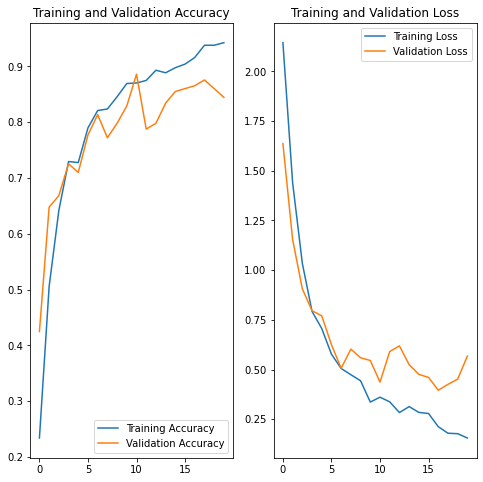

In [19]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prediction test

In [20]:
img = tf.keras.utils.load_img('./prediction/1.jpg', target_size=(img_height, img_width))  #We finally test our code with images dedicated for prediction (not included in the dataset for trainig and validation)
img_array = tf.keras.utils.img_to_array(img) 
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to CROW with a 99.07 percent confidence.
